In [8]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [9]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [33]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])


In [35]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# Create data loaders for our datasets
training_loader = torch.utils.data.DataLoader(training_data, batch_size=4,
                                             shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4,
                                         shuffle=False)

In [36]:
print("---------Training data specifications---------")
print(training_data)
print("\n---------Test data specifications---------")
print(test_data)

---------Training data specifications---------
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

---------Test data specifications---------
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


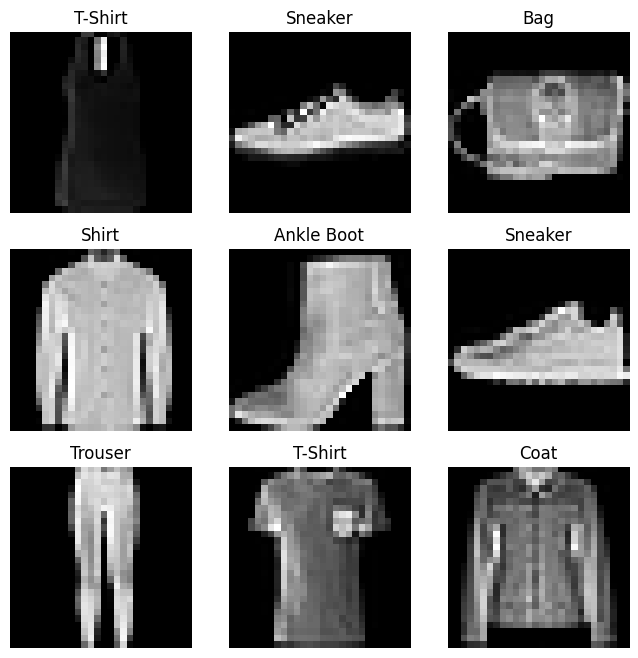

In [37]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

figure = plt.figure(figsize = (8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size = (1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [38]:
import torch.nn as nn
import torch.nn.functional as F

# model
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 4x4 from image dimensions
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = GarmentClassifier()

In [39]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [51]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        
        # zero gradient for every batch
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            print(' batch {} loss: {}'.format(i+1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        
    return last_loss

In [52]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}'.format(epoch_number + 1))
    
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    running_vloss = 0.0
    
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization
    model.eval()
    
    # Disable gradient computation and reduce memory consumption
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
            
    avg_vloss = running_vloss / (i + 1)
    print('Loss train {} valid {}'.format(avg_loss, avg_vloss))
    
    # Log the running loss averaged per batch for both training and test
    writer.add_scalars('Training vs. Test Loss', {
        'Training': avg_loss, 'Test' : avg_vloss},
                      epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_loss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1


EPOCH 1
 batch 1000 loss: 0.5144956053212518
 batch 2000 loss: 0.4931873078364879
 batch 3000 loss: 0.48067030470713507
 batch 4000 loss: 0.4595239312671474
 batch 5000 loss: 0.4437621140226256
 batch 6000 loss: 0.4278201093359676
 batch 7000 loss: 0.42870771290169796
 batch 8000 loss: 0.4295654805178056
 batch 9000 loss: 0.4295957465525134
 batch 10000 loss: 0.3832985374088748
 batch 11000 loss: 0.3747974550347717
 batch 12000 loss: 0.39965955767451666
 batch 13000 loss: 0.39027137761516495
 batch 14000 loss: 0.37268362584002895
 batch 15000 loss: 0.37061696648426007
Loss train 0.37061696648426007 valid 0.4007018506526947
EPOCH 2
 batch 1000 loss: 0.3680183398362133
 batch 2000 loss: 0.34855824817194664
 batch 3000 loss: 0.35967226924763235
 batch 4000 loss: 0.3723070726985752
 batch 5000 loss: 0.34964710091409507
 batch 6000 loss: 0.3236861920786323
 batch 7000 loss: 0.32792311525554396
 batch 8000 loss: 0.33711826787125027
 batch 9000 loss: 0.33929597921087407
 batch 10000 loss: 0.3